# plaq-u-net: multi-patch consensus U-Net for automated detection and segmentation of the carotid arteries on black blood MRI sequences

E. Lavrova, 2022

This is a code supporting the corresponding paper.

Packages import:

In [1]:
import numpy as np
import os
import glob
from skimage.measure import label
import pydicom
import matplotlib.pyplot as plt
import pandas as pd
from skimage import morphology
from scipy.stats import iqr
from scipy.stats import binom_test

In [2]:
def calculate_dice(mask_1, mask_2):
    intersection = np.sum(mask_1*mask_2)
    sum_area = np.sum(mask_1) + np.sum(mask_2)
    return 2*intersection/sum_area

def calculate_overlap(mask_1, mask_2):
    intersection = np.sum(mask_1*mask_2)
    min_area = min(np.sum(mask_1), np.sum(mask_2))
    return intersection/min_area

In [3]:
def path2array(dcm_path, cut=True):
    arr_dcm = pydicom.read_file(dcm_path, force = True)
    arr_dcm.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
    arr = arr_dcm.pixel_array
    if cut:
        arr = arr[8:-8,8:-8]
    return arr

In [4]:
def detect_label(label_mask, gt_mask):
    
    max_overlap = 0
    max_label = 100
    max_dice = 0
    
    for l in range(1, np.max(label_mask)+1):
        
        label_mask_l = label_mask==l
        d = calculate_dice(label_mask_l, gt_mask)
        o = calculate_overlap(label_mask_l, gt_mask)
        
        if o>max_overlap:
            
            max_overlap = o
            max_label = l
            max_dice = d        
            
    return max_label, max_overlap, max_dice

In [5]:
import scipy.stats
import math
import random


def clopper_pearson(x, n, alpha=0.05):
    """Estimate the confidence interval for a sampled Bernoulli random
    variable.
    `x` is the number of successes and `n` is the number trials (x <=
    n). `alpha` is the confidence level (i.e., the true probability is
    inside the confidence interval with probability 1-alpha). The
    function returns a `(low, high)` pair of numbers indicating the
    interval on the probability.
    """
    b = scipy.stats.beta.ppf
    lo = b(alpha / 2, x, n - x + 1)
    hi = b(1 - alpha / 2, x + 1, n - x)
    return 0.0 if math.isnan(lo) else lo, 1.0 if math.isnan(hi) else hi

In [87]:
def get_outcomes(sub_names, ds_dir, results_dir, cut=True):
    
    df_outcomes = []
    
    detect_slice = []
    dice_slice = []
    overlap_slice = []
    
    for sub_name in sub_names:
    
        rec = {'sub': sub_name}

        gt_sub_dir = ds_dir + sub_name + '/MASSExport/'

        filenames = os.listdir(gt_sub_dir)
        filenames.sort()

        mask2d_gt_0 = path2array(gt_sub_dir + '/' + filenames[0], cut=cut)
        dim = mask2d_gt_0.shape

        mask3d_pred = np.zeros([dim[0], dim[1], len(filenames)], dtype=np.uint8)
        mask3d_gt = np.zeros([dim[0], dim[1], len(filenames)], dtype=np.uint8)

        counter = 0

        detect_slice_sub = []
        dice_slice_sub = []
        overlap_slice_sub = []

        detected=0

        for filename in filenames:

            sl = filename[-17:-11]
            gt_path = gt_sub_dir + '/' + filename
            pred_path = glob.glob(results_dir + '/' + sub_name + '*/*' + sl + '*.npy')[0]

            mask2d_gt = (path2array(gt_path, cut=cut)>0)&(path2array(gt_path, cut=cut)<7)
            mask2d_pred = np.load(pred_path)

            mask3d_gt[:, :, counter] = mask2d_gt

            mask2d_pred_processed = morphology.remove_small_objects(mask2d_pred>0.5, 100, connectivity=3)
            mask2d_pred_labeled = label(mask2d_pred_processed)

            comp_label, comp_overlap, comp_dice = detect_label(mask2d_pred_labeled, mask2d_gt)
            mask3d_pred[:, :, counter] = (mask2d_pred_labeled==comp_label).astype(np.uint8)

            if (np.sum(mask2d_gt)>0)&(comp_overlap>0.5):
                detected = 1

            detect_slice_sub.append(detected)
            dice_slice_sub.append(comp_dice)
            overlap_slice_sub.append(comp_overlap)
            
            detect_slice.append(detected)
            dice_slice.append(comp_dice)
            overlap_slice.append(comp_overlap)

            detected=0
            counter+=1

        comp_overlap_3d = calculate_overlap(mask3d_pred, mask3d_gt)
        comp_dice_3d = calculate_dice(mask3d_pred, mask3d_gt)

        rec['detect_slice'] = detect_slice_sub
        rec['overlap_slice'] = overlap_slice_sub
        rec['dice_slice'] = dice_slice_sub

        rec['detect_patient'] = int(comp_overlap_3d>0.5)
        rec['overlap_patient'] = comp_overlap_3d
        rec['dice_patient'] = comp_dice_3d

        df_outcomes.append(rec)

    df_outcomes = pd.DataFrame(df_outcomes)
        
    print ('Slice\n')

    print ('Mean TPR, OC, DSC: ', np.mean(detect_slice), np.mean(overlap_slice), np.mean(dice_slice))
    print ('Median TPR, OC, DSC: ', np.median(detect_slice), np.median(overlap_slice), np.median(dice_slice))
    print ('IQR TPR, OC, DSC: ', iqr(detect_slice), iqr(overlap_slice), iqr(dice_slice))
    print ('CP 90% CI TPR: ', clopper_pearson(x=np.sum(detect_slice), n=len(detect_slice), alpha=0.1))

    plt.figure(figsize=(15, 3))

    plt.subplot(1, 3, 1)
    plt.hist(detect_slice)
    plt.title('TPR')

    plt.subplot(1, 3, 2)
    plt.hist(overlap_slice)
    plt.title('OC')

    plt.subplot(1, 3, 3)
    plt.hist(dice_slice)
    plt.title('DSC')

    plt.show()

    print ('Patient\n')

    print ('Mean TPR, OC, DSC: ', 
           np.mean(df_outcomes['detect_patient']), 
           np.mean(df_outcomes['overlap_patient']), 
           np.mean(df_outcomes['dice_patient']))

    print ('Median TPR, OC, DSC: ',
           np.median(df_outcomes['detect_patient']), 
           np.median(df_outcomes['overlap_patient']), 
           np.median(df_outcomes['dice_patient']))

    print ('IQR TPR, OC, DSC: ',
           iqr(df_outcomes['detect_patient']), 
           iqr(df_outcomes['overlap_patient']), 
           iqr(df_outcomes['dice_patient']))

    print ('CP 90% CI TPR: ',
           clopper_pearson(x=np.sum(np.array(df_outcomes['detect_patient'])), 
                           n=len(np.array(df_outcomes['detect_patient'])), alpha=0.1))
    
    return df_outcomes

In [29]:
def get_outcomes_newstrategy(sub_names, ds_dir, results_dir, cut=True):
    
    df_outcomes = []
    
    detect_slice = []
    dice_slice = []
    overlap_slice = []
    
    for sub_name in sub_names:
    
        rec = {'sub': sub_name}

        gt_sub_dir = ds_dir + sub_name + '/MASSExport/'

        filenames = os.listdir(gt_sub_dir)
        filenames.sort()

        mask2d_gt_0 = path2array(gt_sub_dir + '/' + filenames[0], cut=cut)
        dim = mask2d_gt_0.shape

        mask3d_pred = np.zeros([dim[0], dim[1], len(filenames)], dtype=np.float)
        mask3d_gt = np.zeros([dim[0], dim[1], len(filenames)], dtype=np.uint8)

        counter = 0

        detect_slice_sub = []
        dice_slice_sub = []
        overlap_slice_sub = []

        detected=0

        for filename in filenames:
            
            print (filename, counter)

            sl = filename[-17:-11]
            gt_path = gt_sub_dir + '/' + filename
            pred_path = glob.glob(results_dir + '/' + sub_name + '*/*' + sl + '*.npy')[0]

            mask2d_gt = (path2array(gt_path, cut=cut)>0)&(path2array(gt_path, cut=cut)<7)
            mask2d_pred = np.load(pred_path)

            mask3d_gt[:, :, counter] = mask2d_gt
            mask3d_pred[:, :, counter] = mask2d_pred
            
            print (np.max(mask2d_pred))
            
            counter+=1

        print (np.max(mask3d_pred), np.max(mask3d_gt))
        mask3d_pred_processed = morphology.remove_small_objects(mask3d_pred>0.5, 100, connectivity=3)
        mask3d_pred_labeled = label(mask3d_pred_processed)
        
        label_weights = []
        
        print (np.max(mask3d_pred_labeled))
        
        for l in range(1, np.max(mask3d_pred_labeled)+1):
            
            mask3d_pred_label = (mask3d_pred_labeled==l).astype(np.uint8)
            weight_label = np.sum(mask3d_pred_label*mask3d_pred)
            rec = {'label': l, 'weight': weight_label}
            label_weights.append(rec)
            
        label_weights = pd.DataFrame(label_weights)
        print (label_weights)
        label_weights.sort_values(by='weight', inplace=True)
        
        max_overlap = 0
        max_label = 100
        max_dice = 0
    
        for l in np.array(label_weights['label'])[:4]:

            mask3d_pred_label = (mask3d_pred_labeled==l).astype(np.uint8)
            d = calculate_dice(mask3d_pred_label, mask3d_gt)
            o = calculate_overlap(mask3d_pred_label, mask3d_gt)

            if o>max_overlap:

                max_overlap = o
                max_label = l
                max_dice = d

        if (max_overlap>0.5):
            detected = 1
        
        rec['detect_patient'] = detected
        rec['overlap_patient'] = max_overlap
        rec['dice_patient'] = max_dice
        
        detected=0
        
        mask3d_pred_ca = (mask3d_pred_labeled==max_label).astype(np.uint8)
        
        for i in range (0, len(filenames)):
            
            dice_slice.append(calculate_dice(mask3d_pred_ca[..., i], mask3d_gt[..., i]))
            overlap_slice.append(calculate_overlap(mask3d_pred_ca[..., i], mask3d_gt[..., i]))
            detect_slice.append(calculate_overlap(mask3d_pred_ca[..., i], mask3d_gt[..., i])>0.5)
            
            dice_slice_sub.append(calculate_dice(mask3d_pred_ca[..., i], mask3d_gt[..., i]))
            overlap_slice_sub.append(calculate_overlap(mask3d_pred_ca[..., i], mask3d_gt[..., i]))
            detect_slice_sub.append(calculate_overlap(mask3d_pred_ca[..., i], mask3d_gt[..., i])>0.5)
            

        rec['detect_slice'] = detect_slice_sub
        rec['overlap_slice'] = overlap_slice_sub
        rec['dice_slice'] = dice_slice_sub

        df_outcomes.append(rec)

    df_outcomes = pd.DataFrame(df_outcomes)
        
    print ('Slice\n')

    print ('Mean TPR, OC, DSC: ', np.mean(detect_slice), np.mean(overlap_slice), np.mean(dice_slice))
    print ('Median TPR, OC, DSC: ', np.median(detect_slice), np.median(overlap_slice), np.median(dice_slice))
    print ('IQR TPR, OC, DSC: ', iqr(detect_slice), iqr(overlap_slice), iqr(dice_slice))
    print ('CP 90% CI TPR: ', clopper_pearson(x=np.sum(detect_slice), n=len(detect_slice), alpha=0.1))

    plt.figure(figsize=(15, 3))

    plt.subplot(1, 3, 1)
    plt.hist(detect_slice)
    plt.title('TPR')

    plt.subplot(1, 3, 2)
    plt.hist(overlap_slice)
    plt.title('OC')

    plt.subplot(1, 3, 3)
    plt.hist(dice_slice)
    plt.title('DSC')

    plt.show()

    print ('Patient\n')

    print ('Mean TPR, OC, DSC: ', 
           np.mean(df_outcomes['detect_patient']), 
           np.mean(df_outcomes['overlap_patient']), 
           np.mean(df_outcomes['dice_patient']))

    print ('Median TPR, OC, DSC: ',
           np.median(df_outcomes['detect_patient']), 
           np.median(df_outcomes['overlap_patient']), 
           np.median(df_outcomes['dice_patient']))

    print ('IQR TPR, OC, DSC: ',
           iqr(df_outcomes['detect_patient']), 
           iqr(df_outcomes['overlap_patient']), 
           iqr(df_outcomes['dice_patient']))

    print ('CP 90% CI TPR: ',
           clopper_pearson(x=np.sum(np.array(df_outcomes['detect_patient'])), 
                           n=len(np.array(df_outcomes['detect_patient'])), alpha=0.1))
    
    return df_outcomes

In [190]:
p_n = 1

gt_sub_dir = ds_dir + sub_names_test[p_n] + '/MASSExport/'
img_sub_dir = ds_dir + sub_names_test[p_n] + '/'

filenames = os.listdir(gt_sub_dir)
filenames.sort()

mask2d_gt_0 = path2array(gt_sub_dir + '/' + filenames[0], cut=True)
dim = mask2d_gt_0.shape

mask3d_pred_processed = np.zeros([dim[0], dim[1], len(filenames)], dtype=np.uint8)
mask3d_pred_out = np.zeros([dim[0], dim[1], len(filenames)], dtype=np.uint8)
mask3d_pred_ca = np.zeros([dim[0], dim[1], len(filenames)], dtype=np.uint8)
mask3d_gt = np.zeros([dim[0], dim[1], len(filenames)], dtype=np.uint8)
img3d = np.zeros([dim[0], dim[1], len(filenames)], dtype=np.float64)

counter = 0

detect_slice_sub = []
dice_slice_sub = []
overlap_slice_sub = []

detected=0

for filename in filenames:
    
    sl = filename[-17:-11]
    gt_path = gt_sub_dir + '/' + filename
    pred_path = glob.glob(results_dir_simple + '/' + sub_names_test[p_n] + '*/*' + sl + '*.npy')[0]
    img_path = glob.glob(img_sub_dir + '*' + sl + '*.dcm')[0]

    mask2d_gt = (path2array(gt_path, cut=True)>0)&(path2array(gt_path, cut=True)<7)
    mask2d_pred = np.load(pred_path)
    img2d = path2array(img_path, cut=True)
    
    mask2d_pred_processed = morphology.remove_small_objects(mask2d_pred>0.5, 100, connectivity=2)
    mask2d_pred_processed = morphology.binary_closing(mask2d_pred_processed, selem=np.ones((3,3)).astype(np.uint8))
    mask2d_pred_processed = morphology.binary_dilation(mask2d_pred_processed, selem=np.ones((1,1)).astype(np.uint8))
    mask2d_pred_labeled = label(mask2d_pred_processed)
    
    label_weights = []
        
    for l in range(1, np.max(mask2d_pred_labeled)+1):

        mask2d_pred_label = (mask2d_pred_labeled==l).astype(np.uint8)
        #weight_label = np.sum(mask2d_pred_label*mask2d_pred)
        #weight_label = np.mean(mask2d_pred_label*mask2d_pred)
        weight_label = np.sum(mask2d_pred_label)*np.mean(mask2d_pred_label*mask2d_pred)
        rec = {'label': l, 'weight': weight_label}
        label_weights.append(rec)

    label_weights = pd.DataFrame(label_weights)
    label_weights.sort_values(by='weight', ascending=False, inplace=True)

    max_overlap = 0
    max_label = 1000
    max_dice = 0

    label_limit = min(4, len(label_weights))
    mask2d_pred_out = np.zeros(mask2d_pred.shape, dtype=np.uint8)
    mask2d_pred_ca = np.zeros(mask2d_pred.shape, dtype=np.uint8)

    for i in range (0, label_limit):

        l = np.array(label_weights['label'])[i]
        mask2d_pred_label = (mask2d_pred_labeled==l).astype(np.uint8)
        d = calculate_dice(mask2d_pred_label, mask2d_gt)
        o = calculate_overlap(mask2d_pred_label, mask2d_gt)
        
        mask2d_pred_out += mask2d_pred_label

        if o>max_overlap:

            max_overlap = o
            max_label = l
            max_dice = d
            mask2d_pred_ca = mask2d_pred_label.copy()
            

    mask3d_gt[:, :, counter] = mask2d_gt
    mask3d_pred_processed[:, :, counter] = mask2d_pred_processed
    mask3d_pred_out[:, :, counter] = mask2d_pred_out
    mask3d_pred_ca[:, :, counter] = mask2d_pred_ca
    img3d[:, :, counter] = img2d

    counter+=1

0


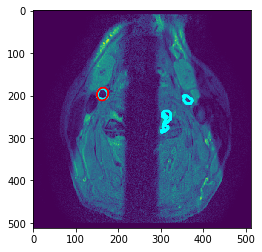

1


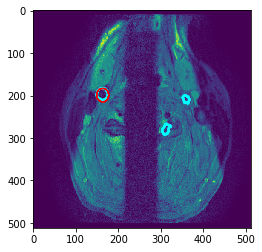

2


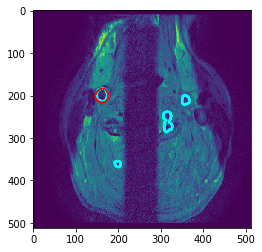

3


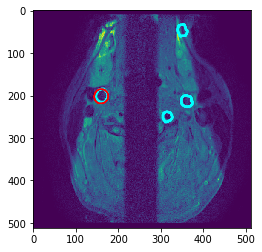

4


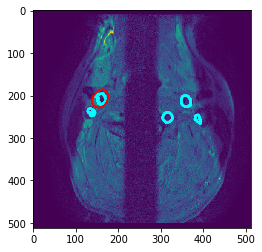

5


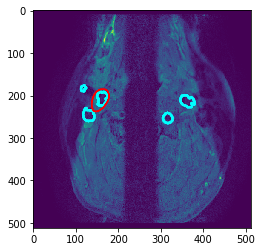

6


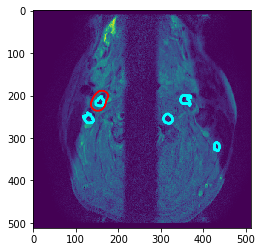

7


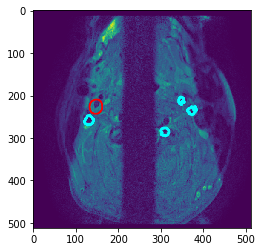

8


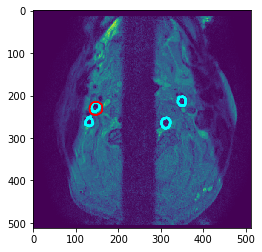

9


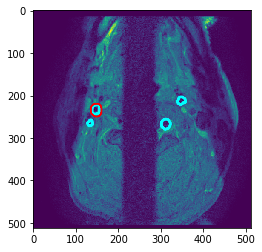

10


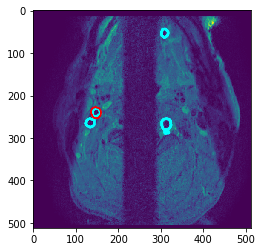

11


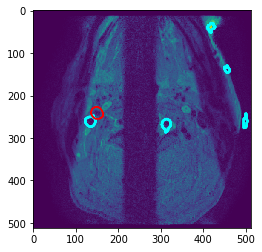

12


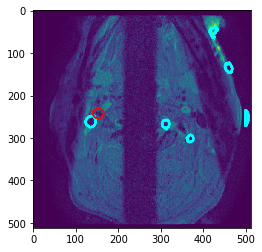

13


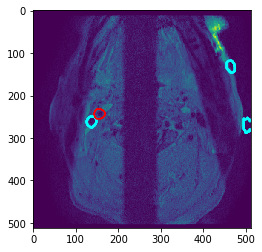

14


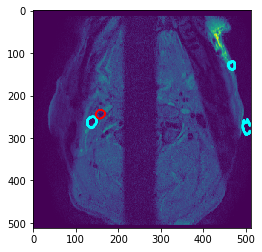

In [191]:
for sl in range(0, mask3d_gt.shape[2]):
    print(sl)
    plt.imshow(img3d[..., sl])
    plt.contour(mask3d_pred_processed[..., sl], colors='cyan', linewidths=2)
    plt.contour(mask3d_gt[..., sl], colors='r', linewidths=1)
    plt.show()

# Test subset

In [8]:
sub_names_test = ['AMC012', 'AMC006', 'MUMC094', 'MUMC027', 'MUMC079', 'MUMC052', 'MUMC127', 'MUMC071', 'MUMC038',
                  'MUMC093', 'MUMC107', 'MUMC022', 'MUMC114', 'MUMC115', 'MUMC069', 'MUMC130', 'MUMC036', 'MUMC007', 
                  'MUMC059', 'MUMC080', 'UMCU036', 'UMCU025', 'UMCU008', 'UMCU034']

In [9]:
ds_dir = '../data/'
results_dir_simple = '../res/maps/plaq-u-net_simple/'
results_dir_aug = '..res/maps/plaq-u-net_aug/'

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


Slice

Mean TPR, OC, DSC:  0.8583333333333333 0.8509491065222715 0.6497404545333458
Median TPR, OC, DSC:  1.0 0.999429874572406 0.7728447600359345
IQR TPR, OC, DSC:  0.0 0.022971065631616105 0.3187455721403145
CP 90% CI TPR:  (0.8245125106562011, 0.8876702671884595)


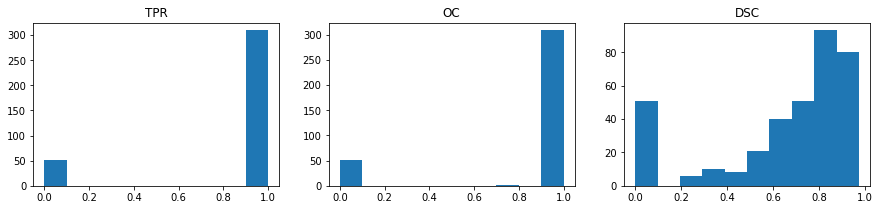

Patient

Mean TPR, OC, DSC:  1.0 0.9819363446643964 0.7029858048932806
Median TPR, OC, DSC:  1.0 0.9927299933252081 0.7156042489432819
IQR TPR, OC, DSC:  0.0 0.012202942198538236 0.16363381462199345
CP 90% CI TPR:  (0.8826538438450513, 1.0)


In [88]:
df_outcomes_test_simple = get_outcomes(sub_names_test, ds_dir, results_dir_simple)

In [89]:
df_outcomes_test_simple

,sub,detect_slice,overlap_slice,dice_slice,detect_patient,overlap_patient,dice_patient
0,AMC012,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[1.0, 0.983633387888707, 1.0, 1.0, 1.0, 1.0, 1...","[0.9191353082465973, 0.9375975039001561, 0.898...",1,0.993601,0.723245
1,AMC006,"[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0]","[1.0, 0.9786476868327402, 1.0, 0.9869753979739...","[0.8957597173144877, 0.8716323296354992, 0.895...",1,0.829152,0.533679
2,MUMC094,"[1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1]","[0.986784140969163, 0.9662162162162162, 0.9661...","[0.9218106995884774, 0.8640483383685801, 0.858...",1,0.984389,0.623098
3,MUMC027,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0.9526627218934911, 0.9682539682539683, 0.956...","[0.9396887159533074, 0.9304099142040038, 0.939...",1,0.957574,0.900385
4,MUMC079,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7299771167048...","[0.8393700787401575, 0.826118855465884, 0.7871...",1,0.973284,0.773695
5,MUMC052,"[1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0]","[1.0, 1.0, 1.0, 1.0, 1.0, 0.07434052757793765,...","[0.8327959465684016, 0.815962441314554, 0.6969...",1,0.939756,0.653945
6,MUMC127,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0.9956647398843931, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.9174434087882823, 0.8766006984866124, 0.803...",1,0.996008,0.734952
7,MUMC071,"[1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1]","[1.0, 1.0, 0.9955555555555555, 1.0, 0.99802761...","[0.7867240319606638, 0.28272251308900526, 0.79...",1,0.999113,0.481814
8,MUMC038,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.5069124423963134, 0.29965156794425085, 0.55...",1,1.000000,0.548861
9,MUMC093,"[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1]","[1.0, 1.0, 0.9812206572769953, 0.9879518072289...","[0.7653250773993808, 0.7234600262123198, 0.777...",1,0.993581,0.695629


In [30]:
df_outcomes_test_simple_newstrategy = get_outcomes_newstrategy(sub_names_test, ds_dir, results_dir_simple)

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


SER_1301_sl0001_ph0001.dcm 0
0.7556585352867842
SER_1301_sl0002_ph0001.dcm 1
0.7755287290783599
SER_1301_sl0003_ph0001.dcm 2
0.7764378418214619
SER_1301_sl0004_ph0001.dcm 3
0.7926132364664227
SER_1301_sl0005_ph0001.dcm 4
0.8279324030736461
SER_1301_sl0006_ph0001.dcm 5
0.7969653337495402
SER_1301_sl0007_ph0001.dcm 6
0.7665823536614577
SER_1301_sl0008_ph0001.dcm 7
0.7588293713051826
SER_1301_sl0009_ph0001.dcm 8
0.7317647989839315
SER_1301_sl0010_ph0001.dcm 9
0.7447435408830643
SER_1301_sl0011_ph0001.dcm 10
0.7454386623576283
SER_1301_sl0012_ph0001.dcm 11
0.7341046500951052
SER_1301_sl0013_ph0001.dcm 12
0.6840806845575571
SER_1301_sl0014_ph0001.dcm 13
0.7320735737448558
SER_1301_sl0015_ph0001.dcm 14
0.6954642893979326
0.8279324030736461 1
10
   label       weight
0      1  4019.165519
1      2  6891.995340
2      3   447.885808
3      4  2658.444332
4      5   145.018195
5      6  1254.484799
6      7    73.949982
7      8   119.604566
8      9   247.204485
9     10  2599.864099


C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in ulong_scalars
  if __name__ == '__main__':


SER_1601_sl0001_ph0001.dcm 0
0.7486921160016209
SER_1601_sl0002_ph0001.dcm 1
0.7283920783083886
SER_1601_sl0003_ph0001.dcm 2
0.6530012496514246
SER_1601_sl0004_ph0001.dcm 3
0.7112546177072958
SER_1601_sl0005_ph0001.dcm 4
0.6595961492275819
SER_1601_sl0006_ph0001.dcm 5
0.6697460656287149
SER_1601_sl0007_ph0001.dcm 6
0.648491988889873
SER_1601_sl0008_ph0001.dcm 7
0.6342920381575823
SER_1601_sl0009_ph0001.dcm 8
0.6875994586152956
SER_1601_sl0010_ph0001.dcm 9
0.6526699685491621
SER_1601_sl0011_ph0001.dcm 10
0.6802285211160779
SER_1601_sl0012_ph0001.dcm 11
0.6914025315394005
SER_1601_sl0013_ph0001.dcm 12
0.7258975903193156
SER_1601_sl0014_ph0001.dcm 13
0.776239356957376
SER_1601_sl0015_ph0001.dcm 14
0.7919054608792067
0.7919054608792067 1
15
    label       weight
0       1   256.187076
1       2   274.904602
2       3   135.649517
3       4   595.760392
4       5    89.668868
5       6  4852.442941
6       7  1906.232409
7       8   228.821662
8       9   734.057946
9      10  3073.063311


C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in longlong_scalars
  after removing the cwd from sys.path.


SER_1401_sl0001_ph0001.dcm 0
0.7383644251385704
SER_1401_sl0002_ph0001.dcm 1
0.7184102567844093
SER_1401_sl0003_ph0001.dcm 2
0.7274334771791473
SER_1401_sl0004_ph0001.dcm 3
0.7453544687014073
SER_1401_sl0005_ph0001.dcm 4
0.7197814841056243
SER_1401_sl0006_ph0001.dcm 5
0.7247934001497924
SER_1401_sl0007_ph0001.dcm 6
0.6961554129375145
SER_1401_sl0008_ph0001.dcm 7
0.7790428852895275
SER_1401_sl0009_ph0001.dcm 8
0.7348679715069011
SER_1401_sl0010_ph0001.dcm 9
0.7164018067996949
SER_1401_sl0011_ph0001.dcm 10
0.6992387702921405
SER_1401_sl0012_ph0001.dcm 11
0.6519047732154528
SER_1401_sl0013_ph0001.dcm 12
0.7725549512966112
SER_1401_sl0014_ph0001.dcm 13
0.7871556259277794
SER_1401_sl0015_ph0001.dcm 14
0.7443006770918146
0.7871556259277794 1
17
    label       weight
0       1  1562.038349
1       2   618.289054
2       3  4470.963299
3       4  4587.220783
4       5    61.671349
5       6   170.819932
6       7  2987.180684
7       8   157.597802
8       9   145.796220
9      10    96.33112

0.675020124996081
SER_1401_sl0007_ph0001.dcm 6
0.8028965890407562
SER_1401_sl0008_ph0001.dcm 7
0.6908428583992645
SER_1401_sl0009_ph0001.dcm 8
0.6956567211309448
SER_1401_sl0010_ph0001.dcm 9
0.7254030314506963
SER_1401_sl0011_ph0001.dcm 10
0.7166687623830512
SER_1401_sl0012_ph0001.dcm 11
0.753816471904771
SER_1401_sl0013_ph0001.dcm 12
0.7318571026508625
SER_1401_sl0014_ph0001.dcm 13
0.6574502361472696
SER_1401_sl0015_ph0001.dcm 14
0.6129744437057525
0.8028965890407562 1
18
    label       weight
0       1   441.827421
1       2   666.203379
2       3  4874.072116
3       4  1085.715477
4       5   305.123000
5       6   120.217652
6       7   747.992869
7       8   605.092961
8       9    69.302106
9      10   497.643619
10     11   283.444580
11     12  1300.949819
12     13   321.614238
13     14   420.608384
14     15  1265.532972
15     16   236.006314
16     17    64.951127
17     18    73.228943
SER_1401_sl0001_ph0001.dcm 0
0.7042696292046458
SER_1401_sl0002_ph0001.dcm 1
0.679503

0.8000467785168439
SER_1401_sl0011_ph0001.dcm 10
0.7442174475872889
SER_1401_sl0012_ph0001.dcm 11
0.7341868671355769
SER_1401_sl0013_ph0001.dcm 12
0.706111314590089
SER_1401_sl0014_ph0001.dcm 13
0.6573696279665455
SER_1401_sl0015_ph0001.dcm 14
0.6899626344675198
0.8172281722072512 1
19
    label       weight
0       1   190.972514
1       2   163.611064
2       3   201.965372
3       4   872.343077
4       5  5571.061940
5       6  6300.747501
6       7   449.254469
7       8  1639.575035
8       9   401.730167
9      10    91.831326
10     11    97.094774
11     12   134.229751
12     13   306.600856
13     14   360.216389
14     15  1921.710994
15     16    96.674590
16     17    69.727328
17     18  2166.105836
18     19   996.728262
SER_1401_sl0001_ph0001.dcm 0
0.8016754930140451
SER_1401_sl0002_ph0001.dcm 1
0.7971203024499118
SER_1401_sl0003_ph0001.dcm 2
0.7998042632825673
SER_1401_sl0004_ph0001.dcm 3
0.8264723411994055
SER_1401_sl0005_ph0001.dcm 4
0.7361233656993136
SER_1401_sl00

TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


Slice

Mean TPR, OC, DSC:  0.8833333333333333 0.863579024436053 0.7749399559939819
Median TPR, OC, DSC:  1.0 0.9846550970302358 0.9012935114102429
IQR TPR, OC, DSC:  0.0 0.03644453577330775 0.16274991681962203
CP 90% CI TPR:  (0.8517278826460298, 0.9101200848556268)


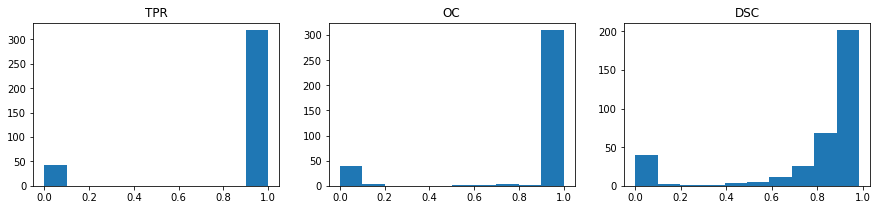

Patient

Mean TPR, OC, DSC:  1.0 0.9210452453574454 0.8254630896713263
Median TPR, OC, DSC:  1.0 0.9511143829223576 0.8445928558840585
IQR TPR, OC, DSC:  0.0 0.06719276548789144 0.10249295687149773
CP 90% CI TPR:  (0.8826538438450513, 1.0)


In [92]:
df_outcomes_test_aug = get_outcomes(sub_names_test, ds_dir, results_dir_aug)

# EMC

In [93]:
sub_names_emc = ['EMC003', 'EMC004', 'EMC005', 'EMC007', 'EMC008', 'EMC009', 'EMC011', 'EMC015', 'EMC018', 'EMC020', 
                 'EMC024', 'EMC027', 'EMC029', 'EMC031', 'EMC032', 'EMC034', 'EMC035', 'EMC036', 'EMC038', 'EMC041', 
                 'EMC042', 'EMC043', 'EMC045', 'EMC046', 'EMC047', 'EMC048', 'EMC049', 'EMC050', 'EMC051', 'EMC052', 
                 'EMC054', 'EMC055', 'EMC056', 'EMC057']

In [94]:
ds_dir = '../data/'
results_dir_simple = '../res/maps/plaq-u-net_simple/'
results_dir_aug = '../res/maps/plaq-u-net_aug/'

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in ulong_scalars
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


Slice

Mean TPR, OC, DSC:  0.390625 0.3862848605677601 0.26297437046553396
Median TPR, OC, DSC:  0.0 0.0 0.0
IQR TPR, OC, DSC:  1.0 1.0 0.6105187741256287
CP 90% CI TPR:  (0.3547198760617443, 0.42747263932086244)


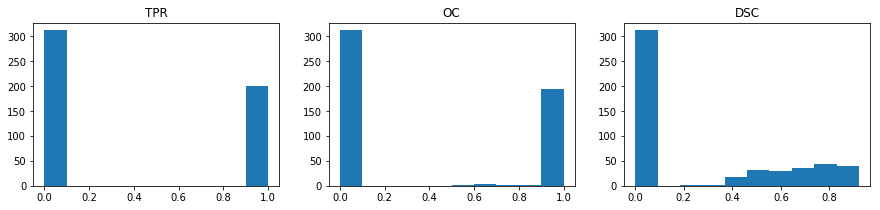

Patient

Mean TPR, OC, DSC:  0.7647058823529411 0.990441046409054 0.3047372457523956
Median TPR, OC, DSC:  1.0 nan 0.3120749747196677
IQR TPR, OC, DSC:  0.0 nan 0.4512305930167153
CP 90% CI TPR:  (0.615343253327413, 0.8771702344111937)


In [97]:
df_outcomes_emc_simple = get_outcomes(sub_names_emc, ds_dir, results_dir_simple, cut=False)

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


Slice

Mean TPR, OC, DSC:  0.79296875 0.7843889326914493 0.6509901633728665
Median TPR, OC, DSC:  1.0 1.0 0.8201155651859877
IQR TPR, OC, DSC:  0.0 0.05572916666666672 0.33898485276402046
CP 90% CI TPR:  (0.7613094684992329, 0.8220864093231477)


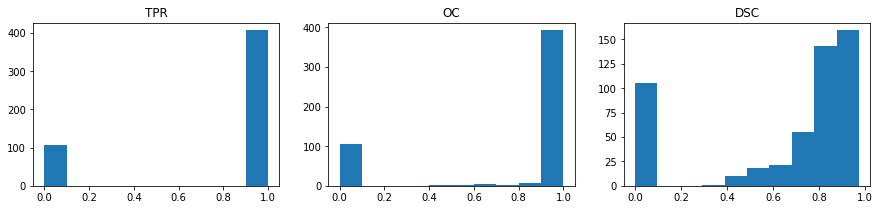

Patient

Mean TPR, OC, DSC:  1.0 0.9730780216754582 0.7048692526329723
Median TPR, OC, DSC:  1.0 0.994935039387492 0.7417271314814119
IQR TPR, OC, DSC:  0.0 0.033281443784337394 0.21456897242755446
CP 90% CI TPR:  (0.9156603566493746, 1.0)


In [98]:
df_outcomes_emc_aug = get_outcomes(sub_names_emc, ds_dir, results_dir_aug, cut=False)